#  Cell assembly detection (CAD)



In [11]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
from elephant.conversion import BinnedSpikeTrain
np.random.seed(4542)

## introducing heterogeneous delays

the function developed in the scan + a shift in time

In [12]:
A_sync = 0.05
shift = 0.
A = [0]+[1.-A_sync]+[0]*8+[A_sync]
spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=10*pq.s)


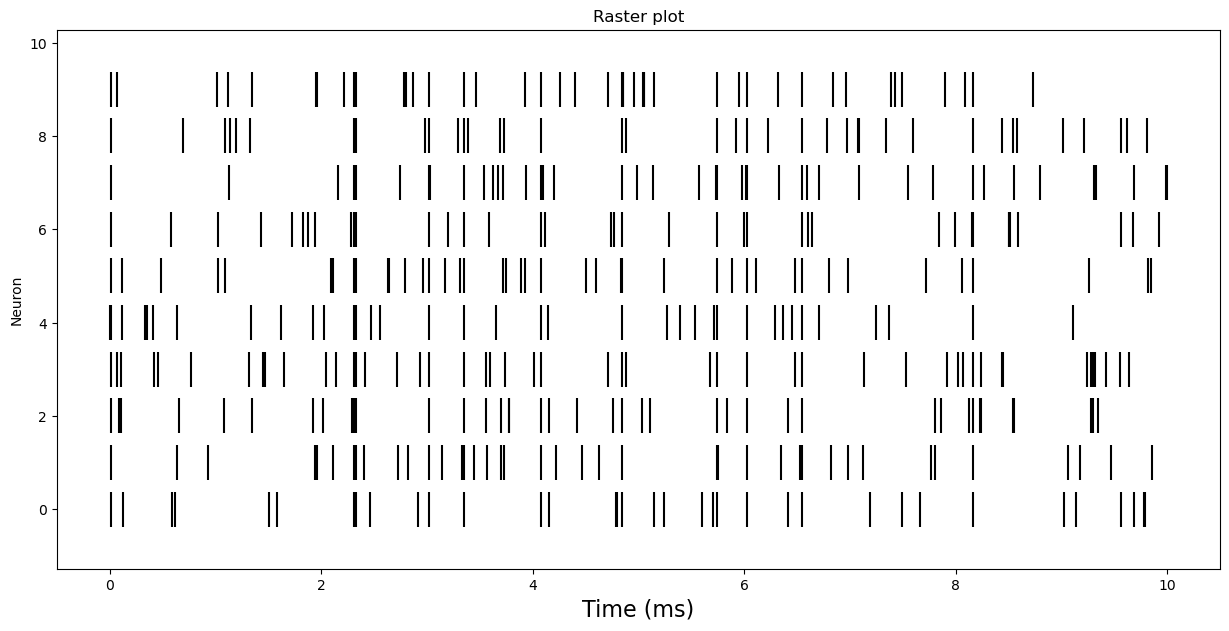

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.eventplot([spiketrains[i].magnitude for i in range(len(spiketrains))], linelengths=0.75, color='black')
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('Neuron')
plt.title("Raster plot");

In [14]:
bst = BinnedSpikeTrain(spiketrains, bin_size=1 * pq.ms)                             

In [15]:
bst

BinnedSpikeTrain(t_start=0.0 s, t_stop=10.0 s, bin_size=0.001 s; shape=(10, 10000), format=csr_matrix)

In [16]:
bst.rescale('ms')

In [17]:
bst

BinnedSpikeTrain(t_start=0.0 ms, t_stop=10000.0 ms, bin_size=1.0 ms; shape=(10, 10000), format=csr_matrix)

In [18]:
from elephant.cell_assembly_detection import cell_assembly_detection
cell_assembly_detection?

Signature:
cell_assembly_detection(
    binned_spiketrain,
    max_lag,
    reference_lag=2,
    alpha=0.05,
    min_occurrences=1,
    size_chunks=100,
    max_spikes=inf,
    significance_pruning=True,
    subgroup_pruning=True,
    same_configuration_pruning=False,
    bool_times_format=None,
    verbose=False,
)
Docstring:
Perform the CAD analysis :cite:`cad-Russo2017_e19428` for the binned
(discretized) spike trains given in the input. The method looks for
candidate significant patterns with lags (number of bins between successive
spikes in the pattern) ranging from `-max_lag` to `max_lag` (the second
parameter of the function). Thus, between two successive spikes in the
pattern there can be at most `max_lag`*`bin_size` units of time.

The method agglomerates pairs of units (or a unit and a preexisting
assembly), tests their significance by a statistical test
and stops when the detected assemblies reach their maximal dimension
(parameter `max_spikes`).

At every agglomeration size

All in one function:

In [19]:
t_stop = 10*pq.s
def generate_and_test(A_sync=A_sync, shift=shift, winlen=1, slope=0., t_stop=t_stop):

    A = [0]+[1.-A_sync]+[0]*8+[A_sync]
    spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=t_stop)

    for i_st in range(10):
        delay = (i_st*slope)*pq.ms
        spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
        spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.s, t_stop=t_stop)

    for i in range(90):
        spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
            rate=5*pq.Hz, t_stop=t_stop))

    bst = BinnedSpikeTrain(spiketrains, bin_size=1 * pq.ms)   
    bst.rescale('ms')                          

    patterns = cell_assembly_detection(bst, max_lag=10)

    return patterns


* changing the synchrony probability to check when SPADE will begin to fail:


In [20]:
for slope_ in np.logspace(-3, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_)
    print(slope_, 'max delay=', 10*slope, 'ms: ', patterns)

0.001 []
0.0027825594022071257 []
0.007742636826811269 []
0.021544346900318832 []
0.05994842503189409 []
0.1668100537200059 []
0.46415888336127775 []
1.2915496650148828 []
3.593813663804626 []
10.0 []
